In [16]:
import pyvisa
from PIL import Image
from IPython.display import display
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

rm = pyvisa.ResourceManager()
rm.list_resources()

inst = rm.open_resource('TCPIP::192.168.23.150::INSTR')
print(inst.query("*IDN?"))

RIGOL TECHNOLOGIES,MSO5072,MS5A210700340,00.01.03.03.00



Setup the instrument sample rate and memory depth for getting reasonable FFT resolution around 10-20MHz

In [48]:
inst.write(':RUN')
inst.write(':CHANnel1:BWLimit 20M')
inst.write(':CHANnel1:COUPling AC')
inst.write(':CHANnel1:OFFSet 0.0')
inst.write(':ACQuire:MDEPth 10M')
inst.write(':TIMebase:MAIN:SCALe 0.01')
print(inst.query(':ACQuire:SRATe?'))

1.000000E+8



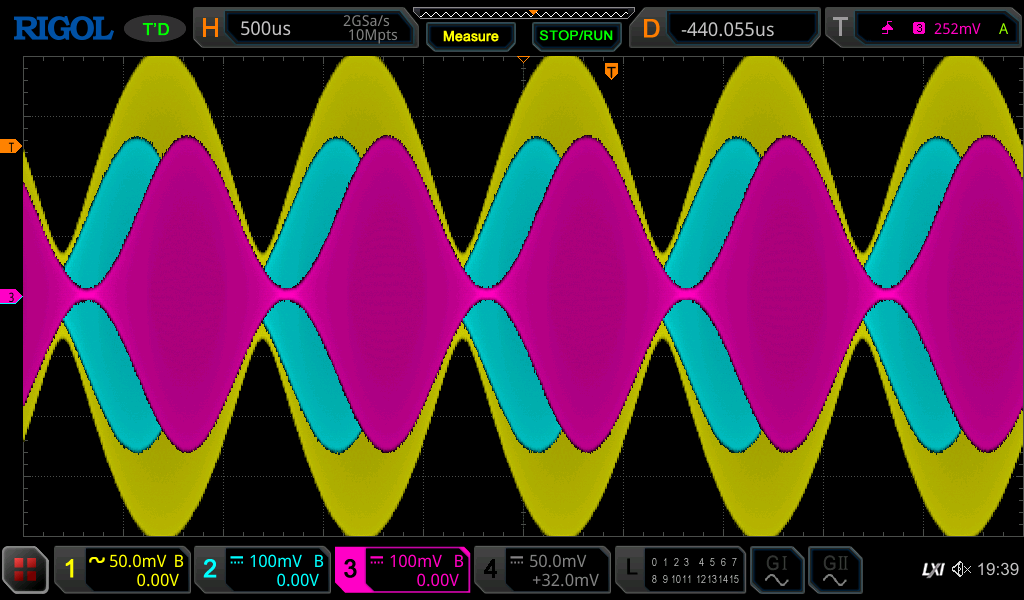

In [53]:
file_name = f'rigol_screen_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.bmp'
image_data = inst.query_binary_values(':DISPlay:DATA?', datatype='B', header_fmt='ieee', container=bytes)
with open(file_name, 'wb') as f:
    f.write(image_data)

display(Image.open(file_name))

Setup the instrument for downloading waveform data from channel 1

In [50]:
inst.write(':WAVeform:SOURce CHANnel1')
inst.write(':WAVeform:MODE RAW')
inst.write(':WAVeform:FORMat BYTE')
inst.write(':WAVeform:POINts RAW')

22

In [51]:
# Instrument must be stopped to read out all mem
inst.write(':STOP')
# Get the raw memory points
inst.write(':WAV:DATA?')
wav_data = inst.read_raw()
# Get the scaling factors for time and voltage
x_incr = float(inst.query(':WAVeform:XINCrement?'))
y_incr = float(inst.query(':WAVeform:YINCrement?'))
y_offset = float(inst.query(':WAVeform:YORigin?'))

# Remove the header and tail byte from the Rigol message array, convert to numpy array for easy proccessing
wav_data_np = np.frombuffer(wav_data, dtype=np.uint8)[11:-1]
# Perform the scaling and create a time vector for plotting
scaled_wav = (wav_data_np.astype(np.float64) - 128 - y_offset) * y_incr
t_wav = np.arange(len(scaled_wav)) * x_incr

capture_dt = datetime.now()

Peaks: Freq - height
10599000Hz - -79.71dB
10699000Hz - -77.40dB
10799000Hz - -73.95dB
10899000Hz - -68.03dB
10998000Hz - -77.82dB
10999000Hz - -27.99dB
11000000Hz - -25.13dB
11001000Hz - -65.11dB
11002000Hz - -78.61dB
11099000Hz - -67.95dB
11199000Hz - -74.07dB
11299000Hz - -77.68dB


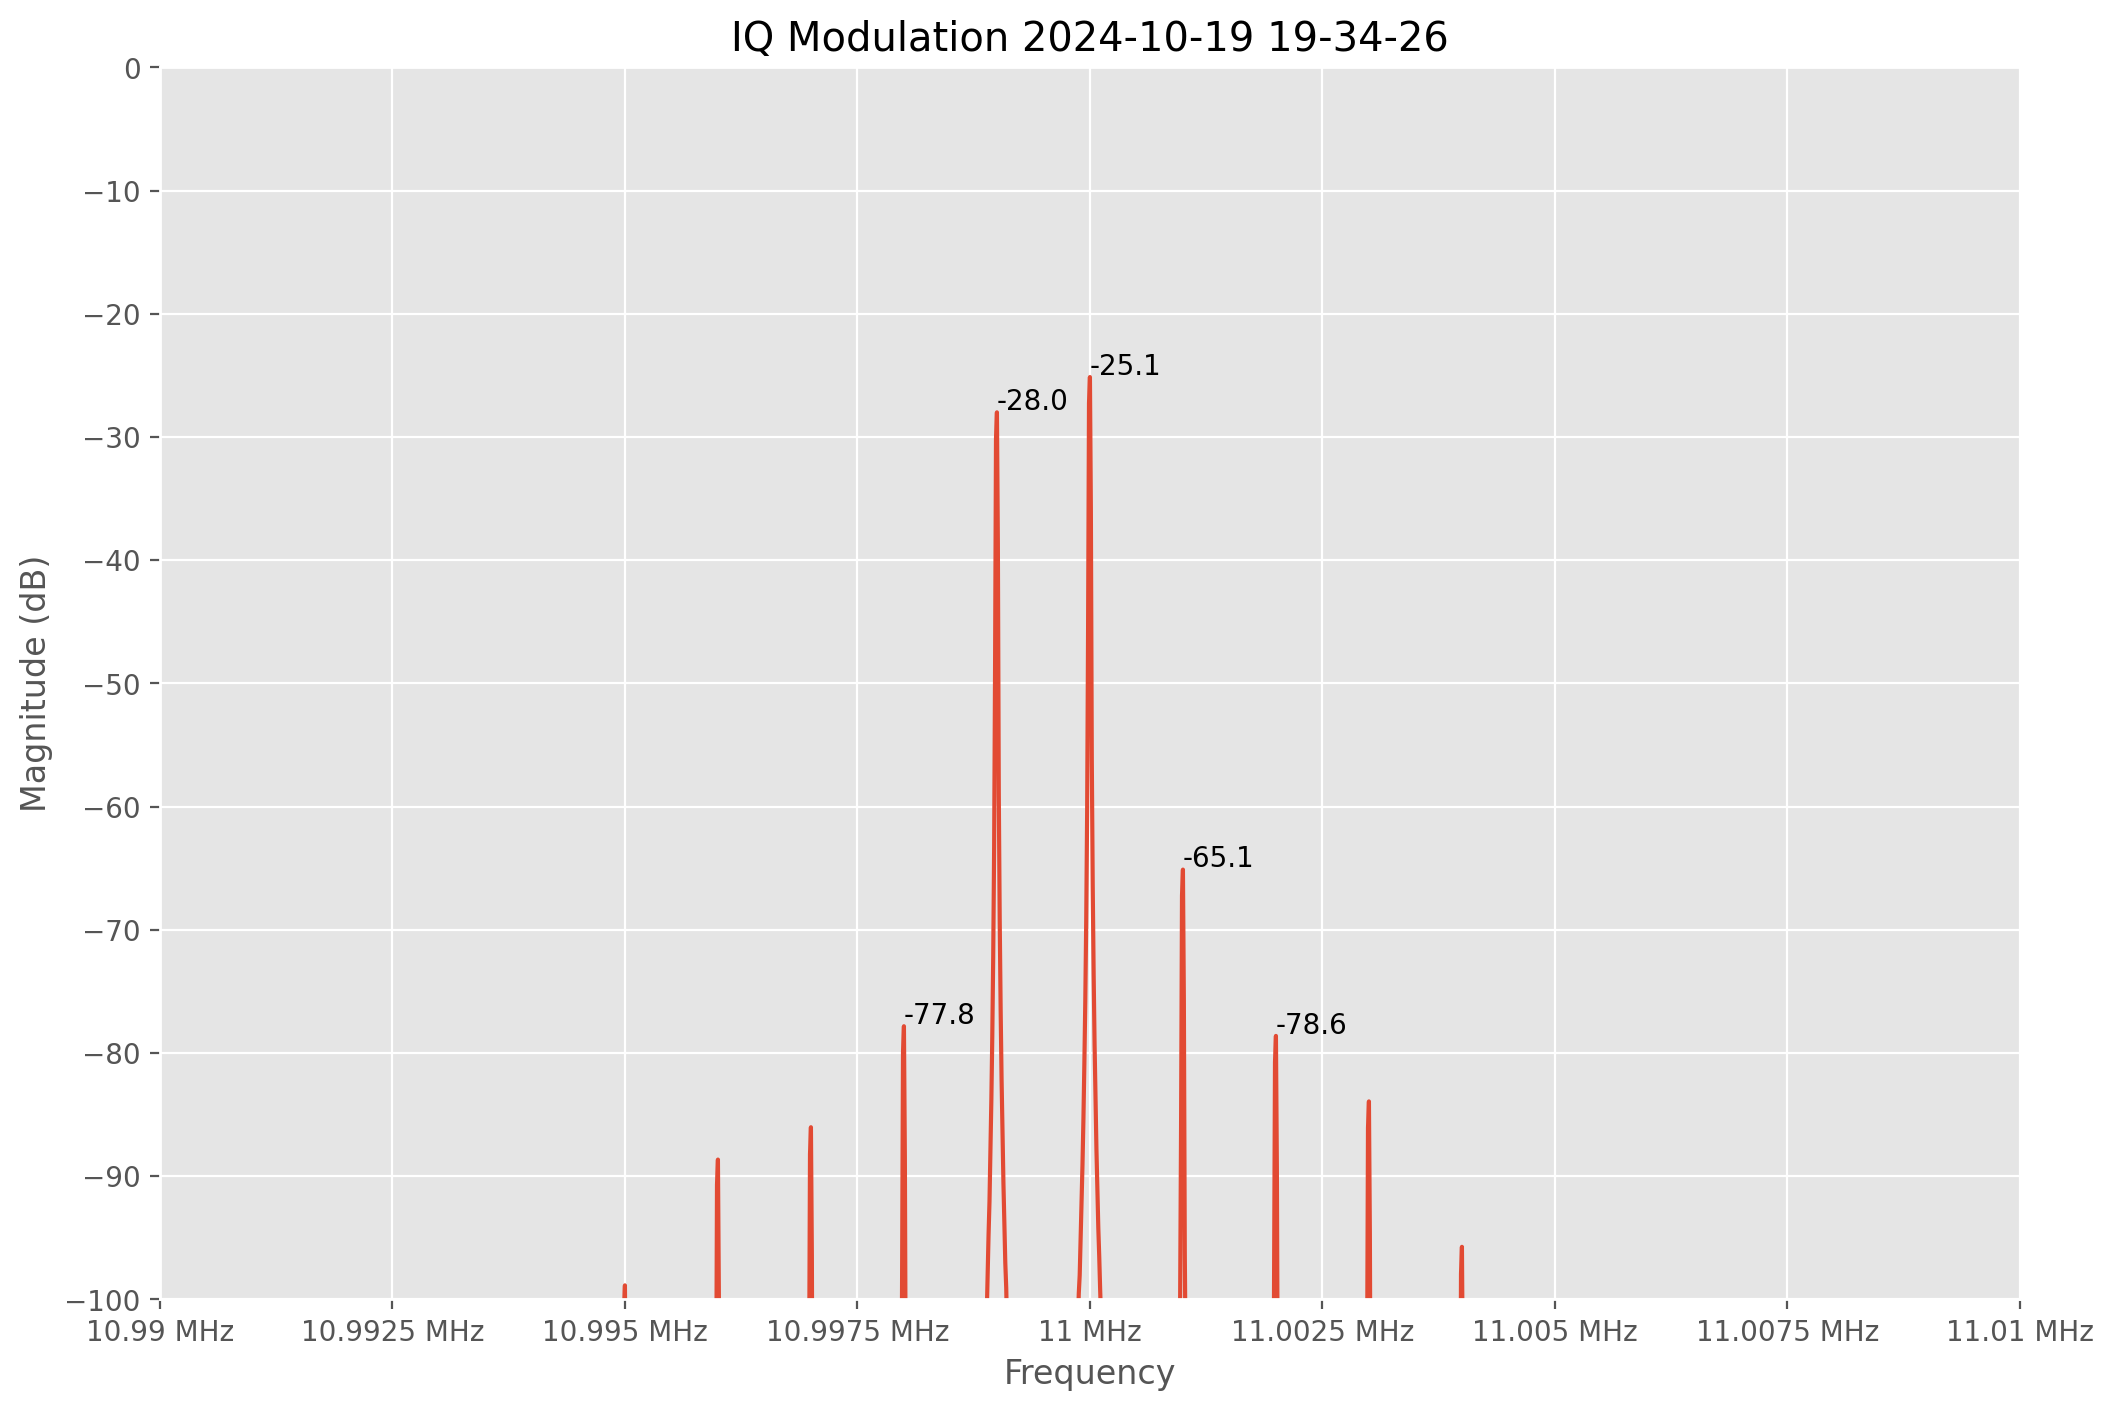

In [54]:
# Some plotting of the scope data
from matplotlib.ticker import EngFormatter, MultipleLocator
from scipy.signal import find_peaks
# Set some plot params for size and DPI
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

plt.style.use('ggplot')

# Plot the magnitude freq spectrum
ax = plt.gca()
ax.xaxis.set_major_formatter(EngFormatter(unit='Hz'))
spectrum, freqs, line = ax.magnitude_spectrum(scaled_wav, Fs=1/x_incr, scale='dB')
ax.set_xlim(11E6 - 10E3, 11E6 + 10E3)
ax.set_ylim(-100, 0)
ax.yaxis.set_major_locator(MultipleLocator(10))

# Find, print and anotate peaks
spectrum_db = 20*np.log10(spectrum) # Note spectrum array is linear scale not dB, so converting to dB to match the plot
peaks = find_peaks(spectrum_db, height=-80)
print('Peaks: Freq - height')
for i in peaks[0]:
    print(f'{freqs[i]:.0f}Hz - {spectrum_db[i]:.2f}dB')
    plt.annotate(f'{spectrum_db[i]:.1f}', (freqs[i], spectrum_db[i] + 0.2))



plt.title(f'IQ Modulation {capture_dt.strftime('%Y-%m-%d %H-%M-%S')}')
plt.show()
